<a href="https://colab.research.google.com/github/lorenzrossi/MachineLearning/blob/master/Model_cnn_four_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Cross Validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
tf.keras.backend.set_floatx("float64")
%load_ext tensorboard


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/CatsDogs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# I define some parameters in order resize image in an uniform way anf I set 3 as number of channels of the image, since I want RGB images
img_width = 100
img_height = 100
img_size = (img_width, img_height)
channels = 3

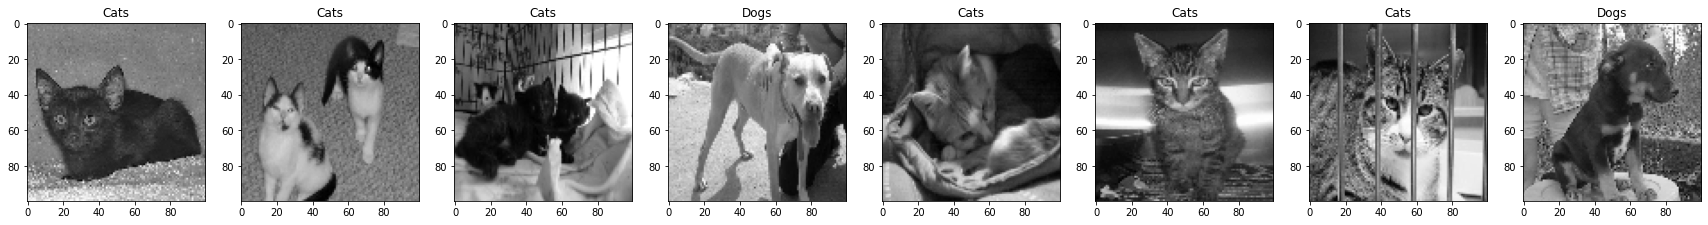

In [3]:
X = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/y.pickle','rb'))
#%%
pets_classes = ['Cats','Dogs']

images_to_plot = 8

gray_channel = 0

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pets_classes[numeric_label])

In [4]:
number_of_classes = len(pets_classes)

In [5]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

In [6]:
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [7]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [8]:
# Hyperparameters
epoch = 50 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/50)
op_3 = RMSprop(learning_rate=1e-4)

In [9]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# Models
Model 1 is the base architecture

Model 2 adds dropout layers

Model 3 adds batch normalization layers 

In [10]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36864     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

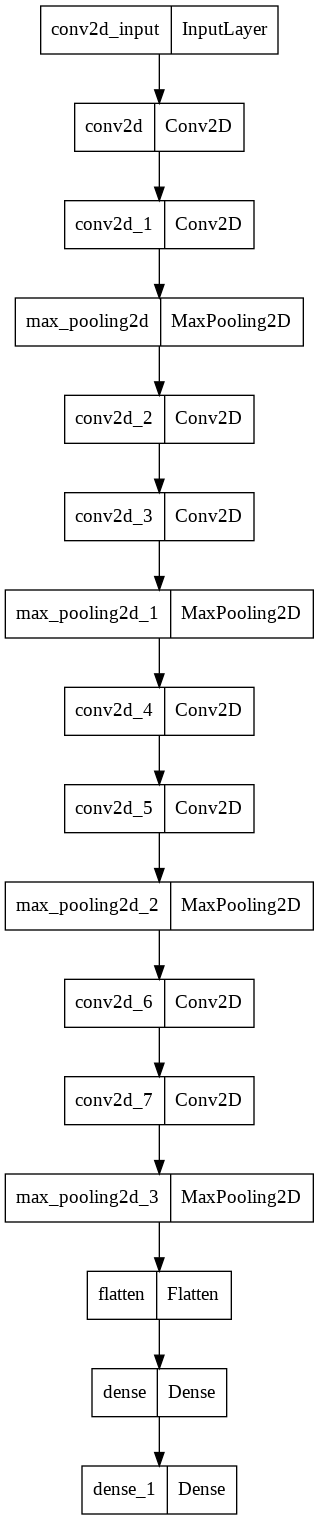

In [11]:
keras.utils.plot_model(model1, 'model1.png')

In [12]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 64)        36864     
                                                      

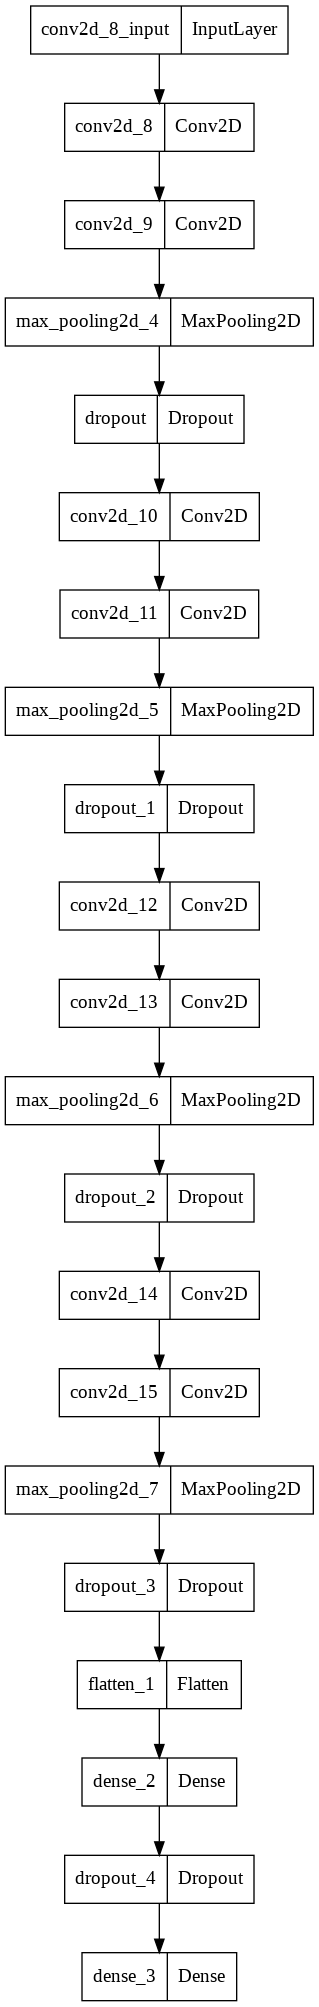

In [13]:
keras.utils.plot_model(model2, 'model2.png')

In [14]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

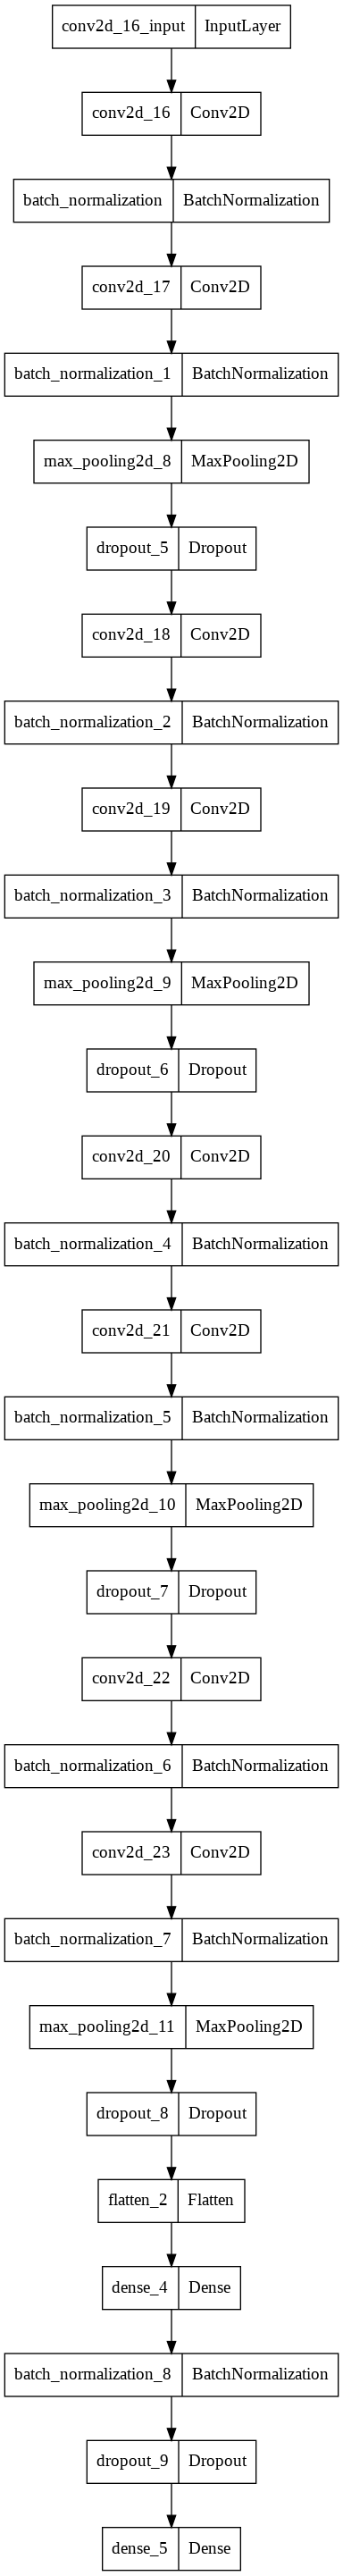

In [15]:
keras.utils.plot_model(model3, 'model3.png')

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 29s 54ms/step - loss: 0.6932 - binary_accuracy: 0.5171 - val_loss: 0.6719 - val_binary_accuracy: 0.5929
Epoch 2/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6567 - binary_accuracy: 0.6131 - val_loss: 0.6256 - val_binary_accuracy: 0.6393
Epoch 3/50
313/313 [==============================] - 16s 52ms/step - loss: 0.5977 - binary_accuracy: 0.6831 - val_loss: 0.5386 - val_binary_accuracy: 0.7280
Epoch 4/50
313/313 [==============================] - 16s 52ms/step - loss: 0.4997 - binary_accuracy: 0.7594 - val_loss: 0.4495 - val_binary_accuracy: 0.7858
Epoch 5/50
313/313 [==============================] - 16s 52ms/step - loss: 0.3913 - binary_accuracy: 0.8246 - val_loss: 0.4133 - val_binary_accuracy: 0.8076
Epoch 6/50
313/313 [==============================] - 16s 52ms/step - loss: 0.3162 - binary_accuracy: 0.8628 - val_loss: 0.3408 - val_binary_accuracy: 0.8515
Epoch 7/50
313/313 [==============================] - 16s 52ms/

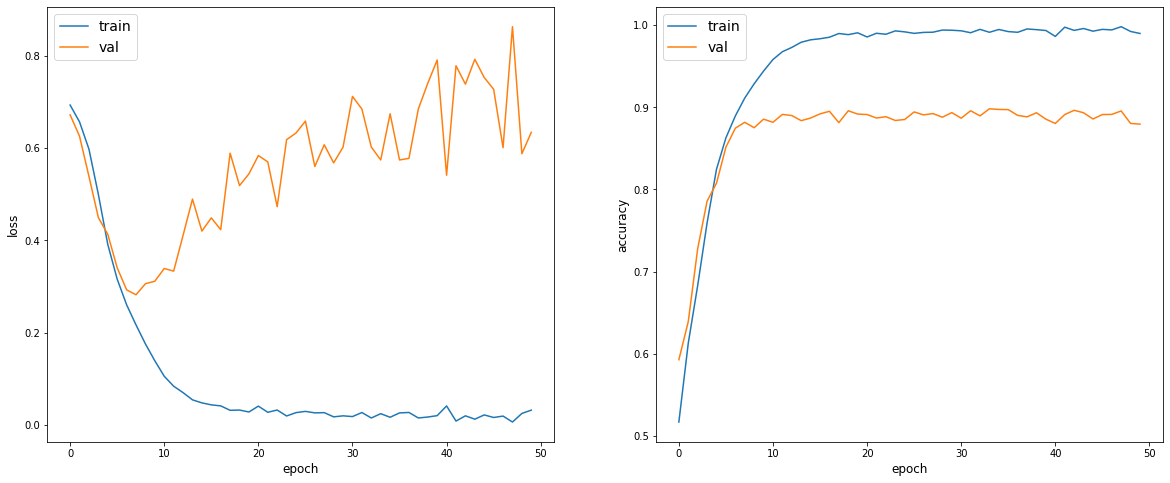

157/157 [==============================] - 2s 11ms/step - loss: 0.6341 - binary_accuracy: 0.8795
test loss, test acc: [0.6340932786966855, 0.8795036028823059]


In [16]:
# TRAINING MODEL 1

# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

Epoch 1/50
313/313 [==============================] - 17s 52ms/step - loss: 0.7112 - binary_accuracy: 0.5093 - val_loss: 0.6881 - val_binary_accuracy: 0.4952
Epoch 2/50
313/313 [==============================] - 16s 51ms/step - loss: 0.6818 - binary_accuracy: 0.5523 - val_loss: 0.6695 - val_binary_accuracy: 0.6191
Epoch 3/50
313/313 [==============================] - 16s 51ms/step - loss: 0.6584 - binary_accuracy: 0.6059 - val_loss: 0.6310 - val_binary_accuracy: 0.6407
Epoch 4/50
313/313 [==============================] - 16s 51ms/step - loss: 0.6335 - binary_accuracy: 0.6451 - val_loss: 0.6074 - val_binary_accuracy: 0.6783
Epoch 5/50
313/313 [==============================] - 16s 51ms/step - loss: 0.6024 - binary_accuracy: 0.6820 - val_loss: 0.5937 - val_binary_accuracy: 0.7214
Epoch 6/50
313/313 [==============================] - 16s 51ms/step - loss: 0.5571 - binary_accuracy: 0.7244 - val_loss: 0.5820 - val_binary_accuracy: 0.7106
Epoch 7/50
313/313 [==============================] 

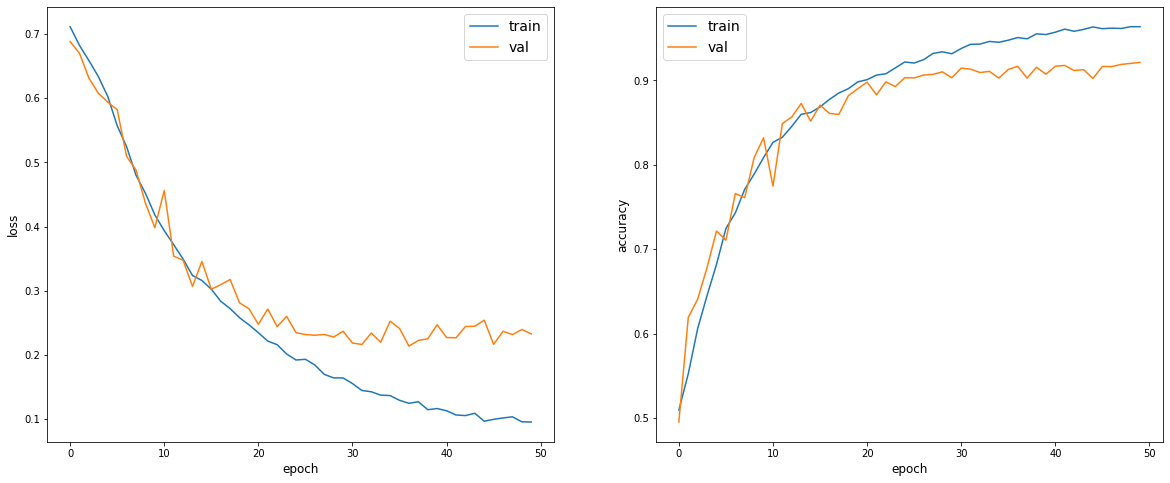

157/157 [==============================] - 2s 11ms/step - loss: 0.2328 - binary_accuracy: 0.9211
test loss, test acc: [0.23277985570510024, 0.9211369095276221]


In [17]:
# TRAINING MODEL 2

# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

Epoch 1/50
313/313 [==============================] - 28s 81ms/step - loss: 0.6994 - binary_accuracy: 0.6211 - val_loss: 0.7765 - val_binary_accuracy: 0.5651
Epoch 2/50
313/313 [==============================] - 25s 80ms/step - loss: 0.5579 - binary_accuracy: 0.7158 - val_loss: 0.6171 - val_binary_accuracy: 0.6349
Epoch 3/50
313/313 [==============================] - 25s 80ms/step - loss: 0.4869 - binary_accuracy: 0.7658 - val_loss: 0.4798 - val_binary_accuracy: 0.7714
Epoch 4/50
313/313 [==============================] - 25s 80ms/step - loss: 0.4248 - binary_accuracy: 0.8048 - val_loss: 0.4584 - val_binary_accuracy: 0.7960
Epoch 5/50
313/313 [==============================] - 25s 80ms/step - loss: 0.3752 - binary_accuracy: 0.8303 - val_loss: 0.4031 - val_binary_accuracy: 0.8181
Epoch 6/50
313/313 [==============================] - 25s 80ms/step - loss: 0.3276 - binary_accuracy: 0.8603 - val_loss: 0.3512 - val_binary_accuracy: 0.8411
Epoch 7/50
313/313 [==============================] 

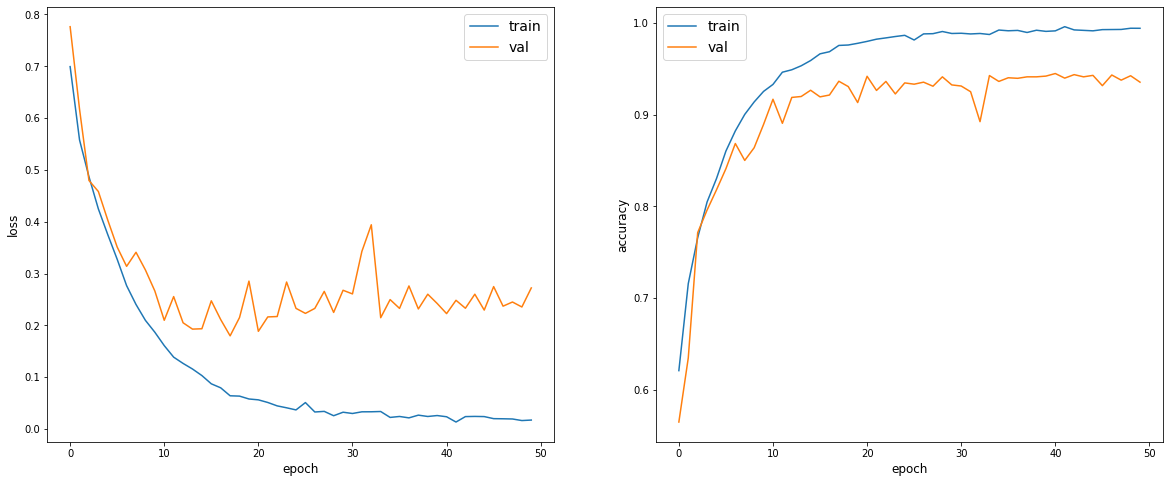

157/157 [==============================] - 2s 13ms/step - loss: 0.2723 - binary_accuracy: 0.9353
test loss, test acc: [0.27232184865365666, 0.9353482786228983]


In [18]:
# TRAINING MODEL 3 with Adam

# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op1 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op1)

Epoch 1/50
625/625 [==============================] - 30s 31ms/step - loss: 0.6911 - binary_accuracy: 0.5219 - val_loss: 0.6658 - val_binary_accuracy: 0.5887
Epoch 2/50
625/625 [==============================] - 19s 30ms/step - loss: 0.6697 - binary_accuracy: 0.5956 - val_loss: 0.6564 - val_binary_accuracy: 0.6617
Epoch 3/50
625/625 [==============================] - 19s 30ms/step - loss: 0.6307 - binary_accuracy: 0.6455 - val_loss: 0.5691 - val_binary_accuracy: 0.6962
Epoch 4/50
625/625 [==============================] - 19s 30ms/step - loss: 0.5819 - binary_accuracy: 0.7002 - val_loss: 0.5326 - val_binary_accuracy: 0.7390
Epoch 5/50
625/625 [==============================] - 19s 30ms/step - loss: 0.5244 - binary_accuracy: 0.7454 - val_loss: 0.4661 - val_binary_accuracy: 0.7822
Epoch 6/50
625/625 [==============================] - 19s 30ms/step - loss: 0.4623 - binary_accuracy: 0.7845 - val_loss: 0.4347 - val_binary_accuracy: 0.7992
Epoch 7/50
625/625 [==============================] 

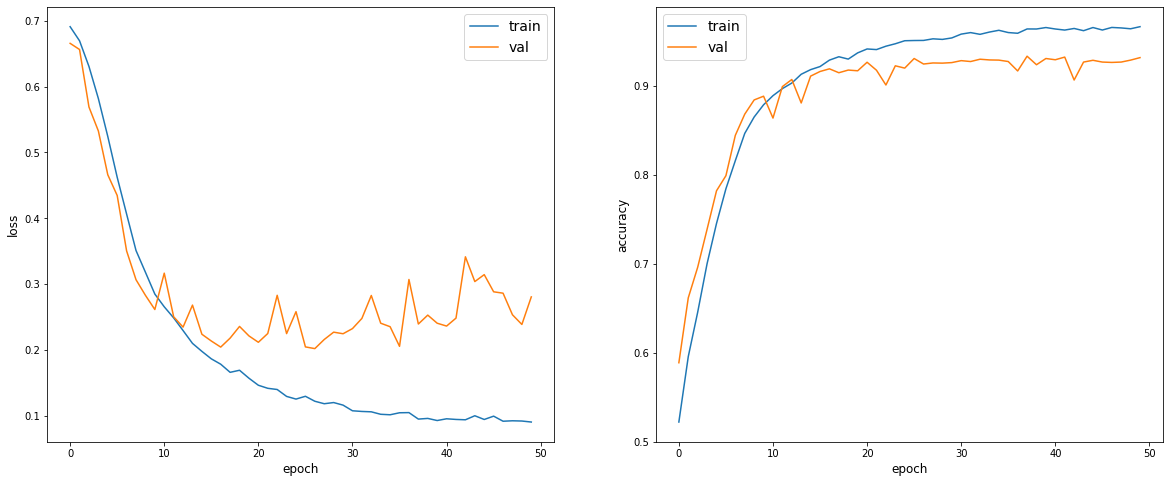

157/157 [==============================] - 2s 11ms/step - loss: 0.2806 - binary_accuracy: 0.9321
test loss, test acc for batch 32: [0.28055243607180336, 0.9321457165732586]
Epoch 1/50
157/157 [==============================] - 17s 96ms/step - loss: 0.6995 - binary_accuracy: 0.5042 - val_loss: 0.6933 - val_binary_accuracy: 0.4880
Epoch 2/50
157/157 [==============================] - 15s 95ms/step - loss: 0.6905 - binary_accuracy: 0.5274 - val_loss: 0.6880 - val_binary_accuracy: 0.5813
Epoch 3/50
157/157 [==============================] - 15s 95ms/step - loss: 0.6634 - binary_accuracy: 0.6091 - val_loss: 0.6535 - val_binary_accuracy: 0.6459
Epoch 4/50
157/157 [==============================] - 15s 95ms/step - loss: 0.6326 - binary_accuracy: 0.6534 - val_loss: 0.6043 - val_binary_accuracy: 0.6988
Epoch 5/50
157/157 [==============================] - 15s 95ms/step - loss: 0.6019 - binary_accuracy: 0.6789 - val_loss: 0.5926 - val_binary_accuracy: 0.6998
Epoch 6/50
157/157 [=================

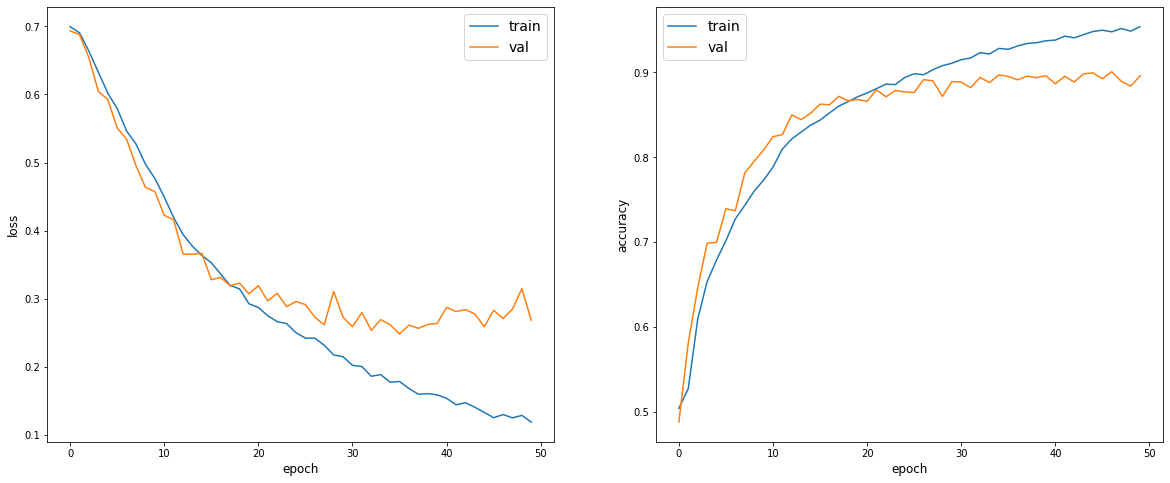

157/157 [==============================] - 2s 11ms/step - loss: 0.2684 - binary_accuracy: 0.8959
test loss, test acc for batch 128: [0.2683795906230824, 0.8959167333867094]
Epoch 1/50
79/79 [==============================] - 18s 183ms/step - loss: 0.7000 - binary_accuracy: 0.5051 - val_loss: 0.6933 - val_binary_accuracy: 0.4880
Epoch 2/50
79/79 [==============================] - 14s 178ms/step - loss: 0.6932 - binary_accuracy: 0.5021 - val_loss: 0.6934 - val_binary_accuracy: 0.4880
Epoch 3/50
79/79 [==============================] - 14s 178ms/step - loss: 0.6932 - binary_accuracy: 0.5021 - val_loss: 0.6933 - val_binary_accuracy: 0.4880
Epoch 4/50
79/79 [==============================] - 14s 178ms/step - loss: 0.6932 - binary_accuracy: 0.5021 - val_loss: 0.6933 - val_binary_accuracy: 0.4880
Epoch 5/50
79/79 [==============================] - 14s 178ms/step - loss: 0.6932 - binary_accuracy: 0.5021 - val_loss: 0.6932 - val_binary_accuracy: 0.4880
Epoch 6/50
79/79 [========================

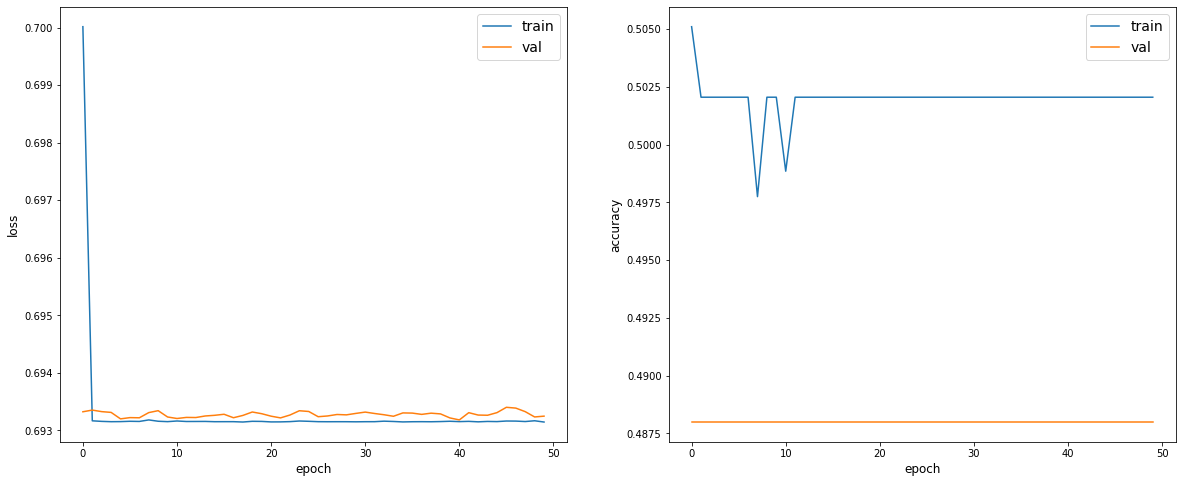

157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - binary_accuracy: 0.4880
test loss, test acc for batch 256: [0.6932465448897366, 0.4879903923138511]


In [10]:
# Model 2 and model 3 are the best, so I run different tries with different batche sizes in order to find the best parameter

batches = [32, 128, 256]

for batch in batches:
  model2 = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
      tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  # compiling the model
  model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

  history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

  performance_plot(history)

  result_2 = model2.evaluate(X_test, y_test)
  print(f"test loss, test acc for batch {batch}:", result_2)

Epoch 1/50
625/625 [==============================] - 42s 46ms/step - loss: 0.6587 - binary_accuracy: 0.6699 - val_loss: 0.5469 - val_binary_accuracy: 0.7242
Epoch 2/50
625/625 [==============================] - 28s 45ms/step - loss: 0.4521 - binary_accuracy: 0.7915 - val_loss: 0.4938 - val_binary_accuracy: 0.7734
Epoch 3/50
625/625 [==============================] - 28s 45ms/step - loss: 0.3300 - binary_accuracy: 0.8547 - val_loss: 0.3555 - val_binary_accuracy: 0.8589
Epoch 4/50
625/625 [==============================] - 28s 45ms/step - loss: 0.2709 - binary_accuracy: 0.8864 - val_loss: 0.2551 - val_binary_accuracy: 0.8935
Epoch 5/50
625/625 [==============================] - 28s 45ms/step - loss: 0.2510 - binary_accuracy: 0.8953 - val_loss: 0.2707 - val_binary_accuracy: 0.8851
Epoch 6/50
625/625 [==============================] - 28s 45ms/step - loss: 0.2065 - binary_accuracy: 0.9146 - val_loss: 0.2813 - val_binary_accuracy: 0.8775
Epoch 7/50
625/625 [==============================] 

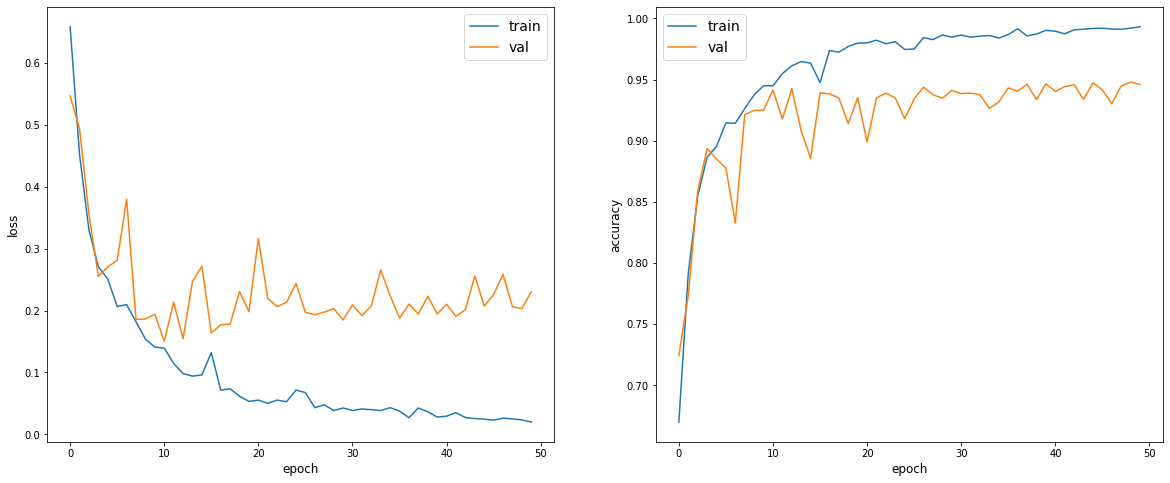

157/157 [==============================] - 2s 13ms/step - loss: 0.2303 - binary_accuracy: 0.9460
Test loss and acc for batch 32: [0.23025809615940696, 0.9459567654123299]
Epoch 1/50
157/157 [==============================] - 28s 150ms/step - loss: 0.7381 - binary_accuracy: 0.6088 - val_loss: 1.0880 - val_binary_accuracy: 0.5058
Epoch 2/50
157/157 [==============================] - 23s 148ms/step - loss: 0.5912 - binary_accuracy: 0.6842 - val_loss: 0.6725 - val_binary_accuracy: 0.5915
Epoch 3/50
157/157 [==============================] - 23s 148ms/step - loss: 0.5359 - binary_accuracy: 0.7304 - val_loss: 0.7617 - val_binary_accuracy: 0.5853
Epoch 4/50
157/157 [==============================] - 23s 148ms/step - loss: 0.4827 - binary_accuracy: 0.7672 - val_loss: 0.7754 - val_binary_accuracy: 0.6309
Epoch 5/50
157/157 [==============================] - 23s 148ms/step - loss: 0.4302 - binary_accuracy: 0.8011 - val_loss: 0.5977 - val_binary_accuracy: 0.7264
Epoch 6/50
157/157 [==============

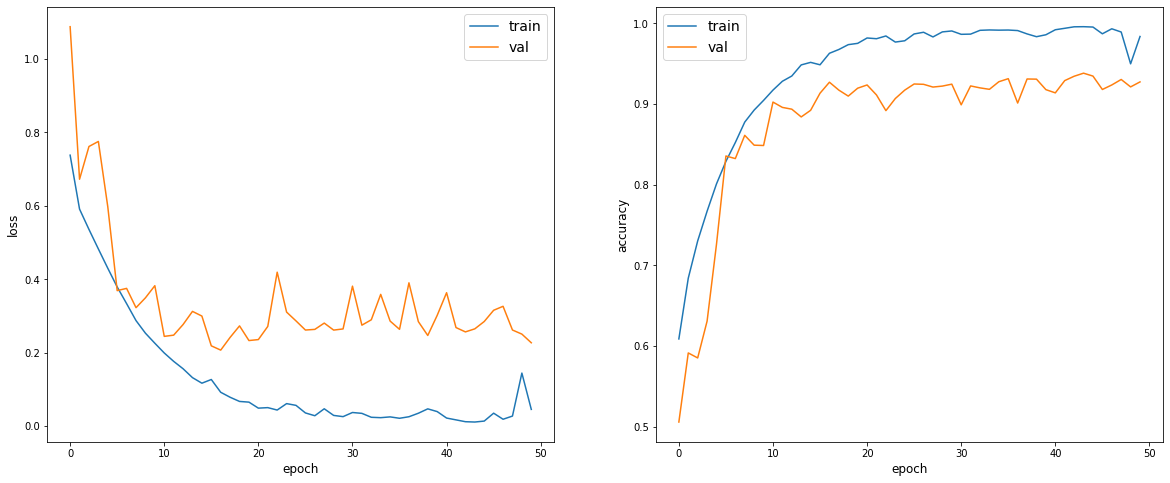

157/157 [==============================] - 2s 13ms/step - loss: 0.2271 - binary_accuracy: 0.9275
Test loss and acc for batch 128: [0.22710578075829568, 0.9275420336269016]
Epoch 1/50
79/79 [==============================] - 28s 287ms/step - loss: 0.8082 - binary_accuracy: 0.5927 - val_loss: 4.2682 - val_binary_accuracy: 0.5064
Epoch 2/50
79/79 [==============================] - 22s 280ms/step - loss: 0.6121 - binary_accuracy: 0.6580 - val_loss: 0.6994 - val_binary_accuracy: 0.5296
Epoch 3/50
79/79 [==============================] - 22s 280ms/step - loss: 0.5735 - binary_accuracy: 0.6965 - val_loss: 0.9912 - val_binary_accuracy: 0.5074
Epoch 4/50
79/79 [==============================] - 22s 280ms/step - loss: 0.5449 - binary_accuracy: 0.7229 - val_loss: 0.8294 - val_binary_accuracy: 0.5074
Epoch 5/50
79/79 [==============================] - 22s 280ms/step - loss: 0.5018 - binary_accuracy: 0.7571 - val_loss: 0.6674 - val_binary_accuracy: 0.6025
Epoch 6/50
79/79 [=========================

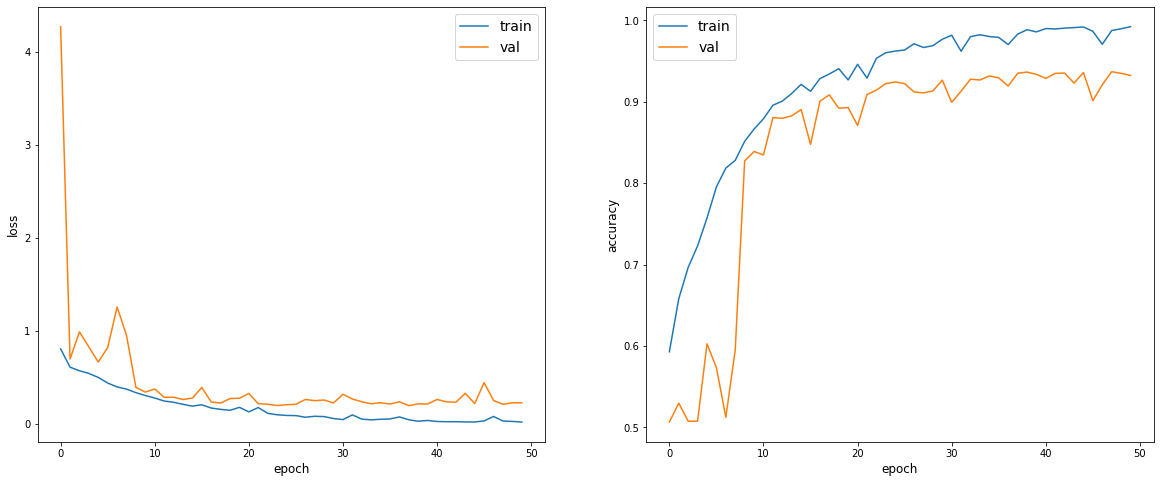

157/157 [==============================] - 2s 13ms/step - loss: 0.2308 - binary_accuracy: 0.9323
Test loss and acc for batch 256: [0.23076991249941275, 0.932345876701361]


In [10]:
batches = [32, 128, 256]

for batch in batches:
  model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

# compiling the model
  model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

  history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

  performance_plot(history)

  result_op1 = model3.evaluate(X_test, y_test)
  print(f"Test loss and acc for batch {batch}:", result_op1)

Epoch 1/50
313/313 [==============================] - 28s 81ms/step - loss: 0.7558 - binary_accuracy: 0.5965 - val_loss: 0.7681 - val_binary_accuracy: 0.5845
Epoch 2/50
313/313 [==============================] - 25s 80ms/step - loss: 0.6749 - binary_accuracy: 0.6491 - val_loss: 0.5900 - val_binary_accuracy: 0.6930
Epoch 3/50
313/313 [==============================] - 25s 80ms/step - loss: 0.6080 - binary_accuracy: 0.6934 - val_loss: 0.7177 - val_binary_accuracy: 0.6435
Epoch 4/50
313/313 [==============================] - 25s 80ms/step - loss: 0.5509 - binary_accuracy: 0.7282 - val_loss: 0.7748 - val_binary_accuracy: 0.6797
Epoch 5/50
313/313 [==============================] - 25s 80ms/step - loss: 0.4975 - binary_accuracy: 0.7651 - val_loss: 0.4831 - val_binary_accuracy: 0.7730
Epoch 6/50
313/313 [==============================] - 25s 80ms/step - loss: 0.4551 - binary_accuracy: 0.7901 - val_loss: 0.4390 - val_binary_accuracy: 0.7958
Epoch 7/50
313/313 [==============================] 

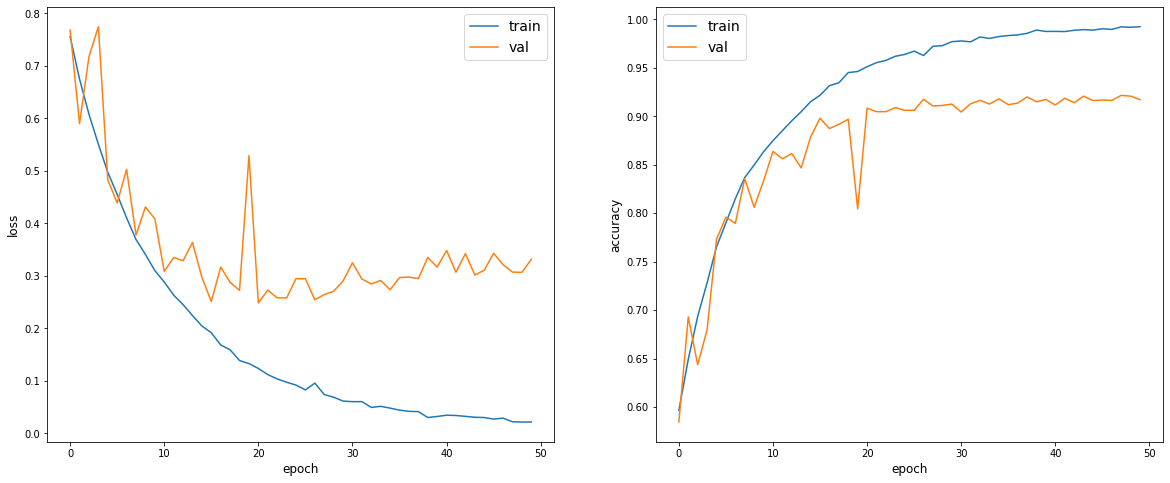

157/157 [==============================] - 2s 13ms/step - loss: 0.3314 - binary_accuracy: 0.9171
test loss, test acc: [0.33143996621821253, 0.9171337069655725]


In [19]:
# The best remains model 3 with batch 32, so now we run the model with different optimizers 

# TRAINING MODEL 3 with SGD

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compiling the model
model3.compile(optimizer = op_2, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = 32, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op2 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op2)

Epoch 1/50
313/313 [==============================] - 29s 82ms/step - loss: 0.8233 - binary_accuracy: 0.6127 - val_loss: 2.1996 - val_binary_accuracy: 0.4952
Epoch 2/50
313/313 [==============================] - 25s 81ms/step - loss: 0.6876 - binary_accuracy: 0.6710 - val_loss: 0.6814 - val_binary_accuracy: 0.6505
Epoch 3/50
313/313 [==============================] - 25s 81ms/step - loss: 0.5918 - binary_accuracy: 0.7227 - val_loss: 0.7287 - val_binary_accuracy: 0.6849
Epoch 4/50
313/313 [==============================] - 25s 81ms/step - loss: 0.5321 - binary_accuracy: 0.7544 - val_loss: 0.9145 - val_binary_accuracy: 0.6831
Epoch 5/50
313/313 [==============================] - 25s 81ms/step - loss: 0.4885 - binary_accuracy: 0.7797 - val_loss: 0.7609 - val_binary_accuracy: 0.7116
Epoch 6/50
313/313 [==============================] - 25s 81ms/step - loss: 0.4481 - binary_accuracy: 0.8006 - val_loss: 0.6145 - val_binary_accuracy: 0.7548
Epoch 7/50
313/313 [==============================] 

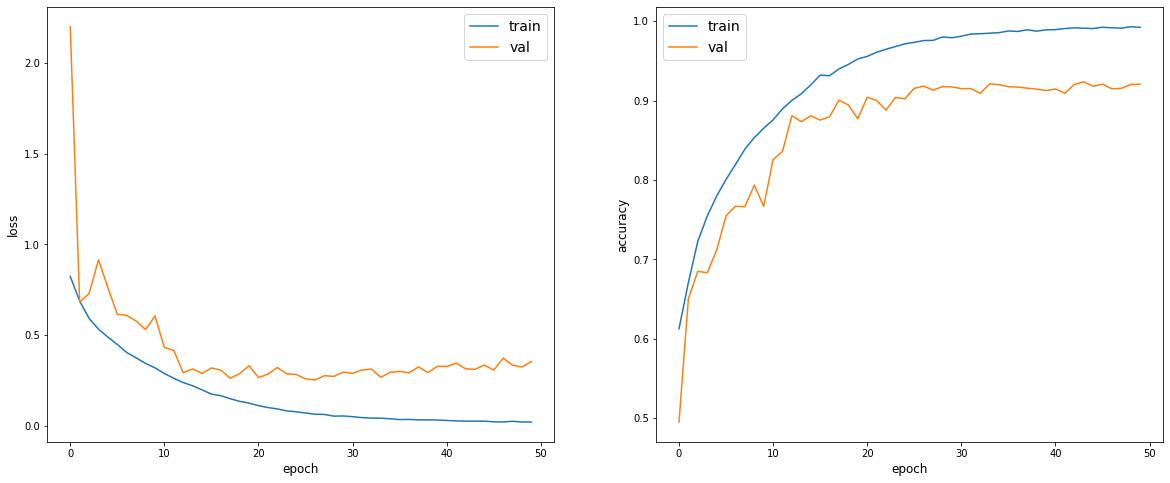

157/157 [==============================] - 2s 12ms/step - loss: 0.3542 - binary_accuracy: 0.9205
test loss, test acc: [0.3542431385399756, 0.9205364291433147]


In [20]:
# TRAINING MODEL 3 with RMSprop

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compiling the model
model3.compile(optimizer = op_3, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = 32, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op3)